In [3]:
import torch


In [4]:
# check that the GPU is working
torch.backends.cudnn.is_acceptable(torch.cuda.FloatTensor(1))

True

In [5]:
# import utility functions for evaluating model output
from utils_120919_pytorch import *

In [6]:
import pandas as pd
import numpy as np
import pickle



In [7]:
# point to correct datafolder for machine type we are running on


# pixie
raw_data_folder = '/data/clin_notes_outcomes/matchminer/training_data/inflection/'
derived_data_folder = '/data/clin_notes_outcomes/matchminer/derived_datasets/inflection/'
model_folder = '/data/clin_notes_outcomes/matchminer/models/inflection/'



In [8]:
# define cohorts

# find first PROFILE specimen for each patient
registration = pd.read_csv(raw_data_folder + 'PT_INFO_STATUS_REGISTRATION.TXT', sep='|', encoding='ISO-8859-1', low_memory=False)[['patient_id', 'dfci_mrn', 'ndi_death_dt']]
registration = registration[~registration.dfci_mrn.isnull() & (~registration.patient_id.isnull())]
registration.patient_id = pd.to_numeric(registration.patient_id)
registration.dfci_mrn = pd.to_numeric(registration.dfci_mrn)
registration.ndi_death_dt = pd.to_datetime(registration.ndi_death_dt)
print("Max NDI death date")
print(np.max(registration.ndi_death_dt))
specimens = pd.read_csv(raw_data_folder + 'GENOMIC_SPECIMEN.TXT', sep='|', encoding='ISO-8859-1', low_memory=False)[['patient_id', 'primary_cancer_diagnosis', 'report_dt']]
specimens.info()

Max NDI death date
2018-12-31 00:00:00
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40768 entries, 0 to 40767
Data columns (total 3 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   patient_id                40768 non-null  int64 
 1   primary_cancer_diagnosis  26639 non-null  object
 2   report_dt                 40768 non-null  object
dtypes: int64(1), object(2)
memory usage: 955.6+ KB


In [9]:
specimens = specimens[~specimens.patient_id.isnull()]
specimens['specimen_date'] = pd.to_datetime(specimens.report_dt)
specimens = specimens.sort_values(by=['patient_id','specimen_date']).groupby(['patient_id']).first()
specimens = pd.merge(registration, specimens, on='patient_id', how='inner')
specimens = specimens[~specimens.dfci_mrn.isnull()]
specimens = specimens[~specimens.primary_cancer_diagnosis.isnull()]

# no leukemia
specimens = specimens[~specimens.primary_cancer_diagnosis.str.contains("leukemia", case=False)]

lung_mrns = specimens[specimens.primary_cancer_diagnosis.str.contains("lung", case=False)].index
breast_mrns = specimens[specimens.primary_cancer_diagnosis.str.contains("breast", case=False)].index
panc_mrns = specimens[specimens.primary_cancer_diagnosis.str.contains("panc", case=False)].index



In [12]:
# pull in previously derived datasets containing report text and outcome variables

training = pd.read_csv(derived_data_folder+'train_prognosis.csv', dtype={'text':'str', 'report_type':'str', 'died_90d':'int32', 'died_180d':'int32','died_270d':'int32','died_360d':'int32', 'new_rx_30d':'int32'})
validation = pd.read_csv(derived_data_folder+'valid_prognosis.csv', dtype={'text':'str', 'report_type':'str', 'died_90d':'int32', 'died_180d':'int32','died_270d':'int32','died_360d':'int32', 'new_rx_30d':'int32'})
test = pd.read_csv(derived_data_folder+'test_prognosis.csv', dtype={'text':'str', 'report_type':'str', 'died_90d':'int32', 'died_180d':'int32','died_270d':'int32','died_360d':'int32', 'new_rx_30d':'int32'})



In [15]:
training['date'] = pd.to_datetime(training['encounter_date'])
validation['date'] = pd.to_datetime(validation['encounter_date'])
test['date'] = pd.to_datetime(test['encounter_date'])




In [16]:


training = training[['dfci_mrn', 'date', 'text', 'report_type', 'encounter_to_end', 'event', 'event_date', 'hybrid_death_dt', 'hybrid_death_ind', 'died_90d', 'died_180d', 'died_270d', 'died_360d', 'new_rx_30d']]
validation = validation[['dfci_mrn', 'date', 'text', 'report_type', 'encounter_to_end', 'event', 'event_date', 'hybrid_death_dt', 'hybrid_death_ind', 'died_90d', 'died_180d', 'died_270d', 'died_360d', 'new_rx_30d']]
test = test[['dfci_mrn', 'date', 'text', 'report_type', 'encounter_to_end', 'event', 'event_date', 'hybrid_death_dt', 'hybrid_death_ind', 'died_90d', 'died_180d', 'died_270d', 'died_360d', 'new_rx_30d']]



In [18]:
training = training[training['report_type'] == 'Imaging']
training = training[training['text'].notnull()]
training = training[~training['text'].str.contains('portable|pa and lateral')]
training = training[training['event_date'].notnull()]
training = training.rename(columns={'date':'encounter_date'})

validation = validation[validation['report_type'] == 'Imaging']
validation = validation[validation['text'].notnull()]
validation = validation[~validation['text'].str.contains('portable|pa and lateral')]
validation = validation[validation['event_date'].notnull()]
validation = validation.rename(columns={'date':'encounter_date'})

test = test[test['report_type'] == 'Imaging']
test = test[test['text'].notnull()]
test = test[~test['text'].str.contains('portable|pa and lateral')]
test = test[test['event_date'].notnull()]
test = test.rename(columns={'date':'encounter_date'})

In [20]:
# pull in previously defined patient-level train/validation/test splits
bigsplit = pd.read_csv(derived_data_folder +'train_val_test_sequenced_unsequenced_io_moresequenced_2-2020.csv')
training_mrns = bigsplit[bigsplit.split == 'train']
validation_mrns = bigsplit[bigsplit.split == 'validation']
true_test_mrns = bigsplit[bigsplit.split == 'test']


In [21]:
# find first palliative rx
treatments = pd.read_csv(raw_data_folder+'TREATMENT_PLAN.TXT', sep='|', encoding='ISO-8859-1', low_memory=False)


In [22]:
treatments.tplan_goal.value_counts()

PALLIATIVE              21802
CURATIVE                11074
CONTROL                  6618
ADJUVANT/NEOADJUVANT      840
MAINTENANCE               661
SUPPORTIVE                438
PREVENTATIVE               54
Name: tplan_goal, dtype: int64

In [ ]:
pall_rx = treatments[treatments['tplan_goal'].isin(['PALLIATIVE', 'CONTROL'])][['patient_id', 'tplan_start_dt', 'std_chemo_plan']]
print(pall_rx.info())
pall_rx['pall_start_dt'] = pd.to_datetime(pall_rx.tplan_start_dt)
pall_rx = pd.merge(registration, pall_rx, on='patient_id', how='inner')
pall_rx = pall_rx.drop(['patient_id', 'tplan_start_dt', 'ndi_death_dt'], axis=1)
pall_rx = pall_rx.sort_values(by=['dfci_mrn', 'pall_start_dt'])

pall_rx = pall_rx.groupby('dfci_mrn').first().reset_index()


ml_pall_rx = pall_rx


In [24]:
# find cancer type (defined using first genomic specimen)
first_specimens = specimens.sort_values(by=['dfci_mrn','report_dt']).groupby('dfci_mrn').first().reset_index()[['dfci_mrn','primary_cancer_diagnosis','report_dt']]
training = pd.merge(training, first_specimens, on='dfci_mrn')
validation = pd.merge(validation, first_specimens, on='dfci_mrn')
test = pd.merge(test, first_specimens, on='dfci_mrn')

In [ ]:
# find first palliative rx if any

training = pd.merge(training, ml_pall_rx, on='dfci_mrn', how='left')
training['encounter_date'] = pd.to_datetime(training.encounter_date)
training['pall_start_dt'] = pd.to_datetime(training.pall_start_dt)
training['report_dt'] = pd.to_datetime(training.report_dt)
training['after_palliative'] = np.where(training.pall_start_dt.isnull() | (training.encounter_date < training.pall_start_dt), 0, 1)
training['after_profile'] = np.where(training.report_dt.isnull() | (training.encounter_date < training.report_dt), 0, 1)

validation = pd.merge(validation, ml_pall_rx, on='dfci_mrn', how='left')
validation['encounter_date'] = pd.to_datetime(validation.encounter_date)
validation['pall_start_dt'] = pd.to_datetime(validation.pall_start_dt)
validation['report_dt'] = pd.to_datetime(validation.report_dt)
validation['after_palliative'] = np.where(validation.pall_start_dt.isnull() | (validation.encounter_date < validation.pall_start_dt), 0, 1)
validation['after_profile'] = np.where(validation.report_dt.isnull() | (validation.encounter_date < validation.report_dt), 0, 1)

test = pd.merge(test, ml_pall_rx, on='dfci_mrn', how='left')
test['encounter_date'] = pd.to_datetime(test.encounter_date)
test['pall_start_dt'] = pd.to_datetime(test.pall_start_dt)
test['report_dt'] = pd.to_datetime(test.report_dt)
test['after_palliative'] = np.where(test.pall_start_dt.isnull() | (test.encounter_date < test.pall_start_dt), 0, 1)
test['after_profile'] = np.where(test.report_dt.isnull() | (test.encounter_date < test.report_dt), 0, 1)



In [ ]:
import random
############## which subset to train on
training['starttime'] = training.groupby('dfci_mrn').encounter_date.transform('first')
training['time'] =  (training['encounter_date'] - training['starttime']).dt.days
train_actual = training[training['encounter_date'] <= '2018-12-31'].reset_index(drop=True)



validation['starttime'] = validation.groupby('dfci_mrn').encounter_date.transform('first')
validation['time'] =  (validation['encounter_date'] - validation['starttime']).dt.days
valid_actual = validation[validation['encounter_date'] <= '2018-12-31'].reset_index(drop=True)

 
test['starttime'] = test.groupby('dfci_mrn').encounter_date.transform('first')
test['time'] =  (test['encounter_date'] - test['starttime']).dt.days
test_actual = test[test['encounter_date'] <= '2018-12-31'].reset_index(drop=True)

In [ ]:
import random
train_actual_mrns = train_actual.dfci_mrn.unique()
random.shuffle(train_actual_mrns)

tiny_train = train_actual[train_actual.dfci_mrn.isin(train_actual_mrns[0:500])].reset_index(drop=True)
tiniest_train = train_actual[train_actual.dfci_mrn.isin(train_actual_mrns[0:10])].reset_index(drop=True)

In [ ]:
print('Number of patients in full training set')
all_train_pts = training.dfci_mrn.nunique()
print(all_train_pts)

print('Number of reports in full training set')
print(training.index.nunique())

In [38]:
train_pts = train_actual.dfci_mrn.unique()

In [ ]:
print('Number of patients in full validation set')
all_valid_pts = validation.dfci_mrn.nunique()
print(all_valid_pts)

print('Number of reports in full validation set')
print(validation.index.nunique())

In [ ]:
print('Number of patients in full test set')
all_test_pts = test.dfci_mrn.nunique()
print(all_test_pts)

print('Number of reports in full test set')
print(test.index.nunique())

In [ ]:
print('Number of patients in train_actual set')
num_train_pts = train_actual.dfci_mrn.nunique()
print(num_train_pts)

print('Number of reports in train_actual set')
print(train_actual.index.nunique())

In [ ]:
print('Number of patients in valid_actual set')
num_validation_pts = valid_actual.dfci_mrn.nunique()

print(num_validation_pts)

print('Number of reports in valid_actual set')
print(valid_actual.index.nunique())

In [ ]:
print('Number of patients in test_actual set')
num_test_pts = test_actual.dfci_mrn.nunique()

print(num_test_pts)

print('Number of reports in test_actual set')
print(test_actual.index.nunique())

In [49]:
from torch.utils import data
from tokenizers import BertWordPieceTokenizer


class PrognosisDataset(data.Dataset):
    def __init__(self, pandas_dataset):
        self.data = pandas_dataset
        self.max_doc_len = 1000
        self.tokenizer = BertWordPieceTokenizer("bert-base-uncased-vocab.txt", lowercase=True)
        self.tokenizer.enable_padding(length=self.max_doc_len)
        self.mrns = self.data.dfci_mrn.unique()
        
    def __len__(self):
        # how many patients in the dataset
        return len(self.mrns)
    
    def __getitem__(self, index):
        # get data for MRN corresponding to index passed
        mrn = self.mrns[index]
        patient = self.data[self.data.dfci_mrn == mrn].copy().reset_index(drop=True)
        
        patient['encounter_date'] = pd.to_datetime(patient['encounter_date'])
        patient = patient.sort_values(by=['encounter_date'])

        start_times = torch.tensor(patient.time / 365, dtype=torch.float32)
        end_times = torch.roll(start_times, -1)
        end_times[-1] = (patient['encounter_to_end'].values[-1] / 365) + start_times[-1]

        events = torch.zeros_like(end_times)
        events[-1] = torch.tensor(patient.event.values[-1], dtype=torch.float32)

    
        y_survival_array = torch.tensor(np.column_stack([patient['encounter_to_end'].values, patient['event'].values]))
        y_new_rx = torch.tensor(patient.new_rx_30d.values, dtype=torch.float32)

        text = patient.text.str.replace('20\d\d',' ')
        
        encoded_list = self.tokenizer.encode_batch([str(x) for x in text])
        for i in range(len(encoded_list)):
            encoded_list[i].truncate(self.max_doc_len)
        encoded_list = [x.ids for x in encoded_list]
        x_text_tensor = torch.tensor(encoded_list, dtype=torch.long)
        
        

        return x_text_tensor, start_times, end_times, events, y_new_rx
        
        

In [51]:
# test dataset loading and output shape
temp = PrognosisDataset(tiniest_train.reset_index(drop=True))

temp_loader = data.DataLoader(temp, batch_size=1, shuffle=True)
temp_iter = iter(temp_loader)
a,b,c,d,e = next(temp_iter)
print(a.shape, b.shape, c.shape, d.shape, e.shape)


torch.Size([1, 7, 1000]) torch.Size([1, 7]) torch.Size([1, 7]) torch.Size([1, 7]) torch.Size([1, 7])


In [52]:
tokenizer = BertWordPieceTokenizer('bert-base-uncased-vocab.txt')
tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [99]:
#model 


from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.nn import LSTM, Linear, Embedding, Conv1d, MaxPool1d, GRU, LSTMCell, GRUCell, Dropout

doc_lstm_dim=64







class NoteCNN(nn.Module):
    def __init__(self, output_dims):
        super(NoteCNN, self).__init__()
        
        self.vocab_size = 30522
        self.embedding_dims=512
        self.word_dim = 256
        self.word_hidden_dim = 256
        
        self.dropout = Dropout(0.1)

        self.output_dims = output_dims
        
        self.main_embedding = Embedding(self.vocab_size, self.embedding_dims)

        self.main_word_CNN1 = Conv1d(self.embedding_dims, self.word_dim, kernel_size=5, stride=1, padding = 1)

        self.main_postword = Linear(self.word_dim, self.word_hidden_dim)

        self.final_common = Linear(self.word_hidden_dim, self.output_dims)
        
    def forward(self, x):
        main = self.main_embedding(x)
        # (num_docs, length_document, embedding_dims)
        #main = self.dropout(main)
        main = main.permute(0,2,1)
        main = self.main_word_CNN1(main)
        main = torch.max(main, axis=2)[0]
        main = self.dropout(main)
        ## (num_docs, embedding_dims)


        
        main = self.main_postword(main)
        main = torch.relu(main)
        main = self.dropout(main)
        
        main = self.final_common(main)
        
        
        return main
 
        
        
    
class PrognosisModel(nn.Module):


    def __init__(self):
        super(PrognosisModel, self).__init__()
        
        self.final_hidden_dim = 128
        
        self.doc_lstm_dim = doc_lstm_dim

        self.note_cnn = NoteCNN(self.final_hidden_dim)
        
        

        self.doc_GRU = GRU(self.final_hidden_dim + 1, self.doc_lstm_dim, bidirectional=False, batch_first=True)

        self.prog_out = Linear(self.doc_lstm_dim, 1)
        self.hazard_activation = nn.Softplus()
        
        self.rx_out = Linear(self.doc_lstm_dim, 1)
        
        self.dropout = Dropout(0.1)
            
        
        

        

    def forward(self, text, start_times, end_times):

        text = text.squeeze(0)
        start_times = start_times.squeeze(0) # now (num_docs,)
        end_times = end_times.squeeze(0) 
        delta_times = torch.cat([torch.tensor([0.]).to('cuda'), start_times[1:] - start_times[:-1]])

        main = self.note_cnn(text)
        main = self.dropout(main)

        main = torch.cat([delta_times.unsqueeze(1), main], dim=1)
        
        # batch axis back
        main = main.unsqueeze(0)
        main, _ = self.doc_GRU(main)
        main = self.dropout(main)
        
        # batch axis gone
        main = main.squeeze(0)
       
        hazard = self.prog_out(main) 
        hazard = self.hazard_activation(hazard)
        
        rx_out = self.rx_out(main)
        
        
        return hazard, rx_out



In [101]:
themodel = PrognosisModel()
themodel.to('cuda')

PrognosisModel(
  (note_cnn): NoteCNN(
    (dropout): Dropout(p=0.1, inplace=False)
    (main_embedding): Embedding(30522, 512)
    (main_word_CNN1): Conv1d(512, 256, kernel_size=(5,), stride=(1,), padding=(1,))
    (main_postword): Linear(in_features=256, out_features=256, bias=True)
    (final_common): Linear(in_features=256, out_features=128, bias=True)
  )
  (doc_GRU): GRU(129, 64, batch_first=True)
  (prog_out): Linear(in_features=64, out_features=1, bias=True)
  (hazard_activation): Softplus(beta=1, threshold=20)
  (rx_out): Linear(in_features=64, out_features=1, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [102]:
# check input and output shapes
a,b,c,d,e = next(temp)
a,b,c,d,e = [x.to('cuda') for x in [a,b,c,d,e]]

themodel.to('cuda')



output = themodel(a,b,c)
print(a.shape)
print(output[0].shape, output[1].shape)



torch.Size([1, 45, 1000])
torch.Size([45, 1]) torch.Size([45, 1])


In [103]:
def survival_loss(linear_h, start_times, end_times, events):
    hazard = linear_h
    
    cum_hazard = hazard * (end_times - start_times)


    loss = -torch.sum(torch.log(hazard)*events - cum_hazard)

    return loss

In [104]:
# train loop
def train_model(model, num_epochs, trainloader, validloader=None):
    
    
    import torch.optim as optim

    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    model.to('cuda')

    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_train_main_loss = 0.0
        mean_train_main_loss = 0.0
        running_train_newrx_loss = 0.0
        mean_train_newrx_loss = 0.0
        
        running_val_main_loss = 0.0
        mean_val_main_loss = 0.0
        running_val_newrx_loss = 0.0
        mean_val_newrx_loss = 0.0
        
        num_train_batches = len(trainloader)
                
        model.train()
        
        preds_h_list = []
        preds_newrx_list = []
        start_times_list = []
        end_times_list = []
        target_event_list = []
        target_newrx_list = []
        
 
        num_dead = 0
        

            
        
        for i, batch in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            a,b,c, y_true, y_true_newrx  = [x.to('cuda') for x in batch]

            
            #get rid of batch1 axis from target labels
            y_true = y_true.squeeze(0)
            y_true_newrx = y_true_newrx.squeeze(0)
            

            #################### actual train step
            # actual prognosis loss
            
            
            optimizer.zero_grad()
            pred_h_t, pred_newrx = model(a,b,c)
            pred_h_t = pred_h_t.squeeze(1)
            pred_newrx = pred_newrx.squeeze(1)
            
            preds_h_list.append(pred_h_t)
            preds_newrx_list.append(pred_newrx)
            start_times_list.append(b.squeeze(0))
            end_times_list.append(c.squeeze(0))
            target_event_list.append(y_true)
            target_newrx_list.append(y_true_newrx)
            

            
            if y_true.sum() > 0:
                num_dead += 1
            
            if num_dead > 3:
                pred_h_t = torch.cat(preds_h_list)
                pred_newrx = torch.cat(preds_newrx_list)
                start_times = torch.cat(start_times_list)
                end_times = torch.cat(end_times_list)
                target_event = torch.cat(target_event_list)
                target_newrx = torch.cat(target_newrx_list)

                
            
                prognosis_loss = survival_loss(pred_h_t, start_times, end_times, target_event)
                newrx_loss = F.binary_cross_entropy_with_logits(pred_newrx, target_newrx)
                total_loss = prognosis_loss + (newrx_loss * 10)
                total_loss.backward()
                optimizer.step()

                running_train_main_loss += prognosis_loss.data.cpu().numpy()
                mean_train_main_loss = running_train_main_loss / (i+1)
                
                running_train_newrx_loss += newrx_loss.data.cpu().numpy()
                mean_train_newrx_loss = running_train_newrx_loss / (i+1)

                
                
                preds_h_list = []
                preds_newrx_list = []
                start_times_list = []
                end_times_list = []
                target_event_list = []
                target_newrx_list = []

                num_dead = 0
                
            # print statistics
            print('Epoch: ' + str(epoch+1) + ', batch: ' + str(i + 1) + '/' + str(num_train_batches) + ', main train loss: ' + str(mean_train_main_loss) + ', newrx train loss: ' + str(mean_train_newrx_loss), end='\r', flush=True)


             
        print('')
            
        if validloader is not None:
            # validate
            valid_batches = len(validloader)

            model.eval()




            preds_h_list = []
            preds_newrx_list = []
            start_times_list = []
            end_times_list = []
            target_event_list = []
            target_newrx_list = []


            num_dead = 0




            for j, batch in enumerate(validloader, 0):
                # get the inputs; data is a list of [inputs, labels]
                a,b,c, y_true, y_true_newrx  = [x.to('cuda') for x in batch]


                #get rid of batch1 axis from target labels
                y_true = y_true.squeeze(0)
                y_true_newrx = y_true_newrx.squeeze(0)

                #################### actual train step
                # actual prognosis loss

                with torch.no_grad():
                    pred_h_t, pred_newrx = model(a,b,c)
                    pred_h_t = pred_h_t.squeeze(1)
                    pred_newrx = pred_newrx.squeeze(1)

                preds_h_list.append(pred_h_t)
                preds_newrx_list.append(pred_newrx)
                start_times_list.append(b.squeeze(0))
                end_times_list.append(c.squeeze(0))
                target_event_list.append(y_true)
                target_newrx_list.append(y_true_newrx)



                if y_true.sum() > 0:
                    num_dead += 1

                if num_dead > 3:
                    pred_h_t = torch.cat(preds_h_list)
                    pred_newrx = torch.cat(preds_newrx_list)
                    start_times = torch.cat(start_times_list)
                    end_times = torch.cat(end_times_list)
                    target_event = torch.cat(target_event_list)
                    target_newrx = torch.cat(target_newrx_list)



                    prognosis_loss = survival_loss(pred_h_t, start_times, end_times, target_event)
                
                
                    newrx_loss = F.binary_cross_entropy_with_logits(pred_newrx, target_newrx)
                    total_loss = prognosis_loss + (newrx_loss * 10)


                    running_val_main_loss += prognosis_loss.data.cpu().numpy()

                    running_val_newrx_loss += newrx_loss.data.cpu().numpy()

        

                    preds_h_list = []
                    preds_newrx_list = []
                    start_times_list = []
                    end_times_list = []
                    target_event_list = []
                    target_newrx_list = []

                    num_dead = 0

                mean_val_main_loss = running_val_main_loss / (j+1)
                mean_val_newrx_loss = running_val_newrx_loss / (j+1)
               
            print('Epoch: ' + str(epoch+1) + ', main val loss: ' + str(mean_val_main_loss) + ', newrx val loss: ' + str(mean_val_newrx_loss), end='\r', flush=True)
        print('')
    



In [ ]:
# # with lstm on end of cnn
themodel = PrognosisModel()
trainloader = data.DataLoader(PrognosisDataset(train_actual), batch_size=1, num_workers=0, shuffle=True)
validloader = data.DataLoader(PrognosisDataset(valid_actual), batch_size=1, num_workers=0, shuffle=True)
train_model(themodel,3, trainloader, validloader)
torch.save(themodel.state_dict(), model_folder+'rnn_direct_hazard_dropout_rehazard.pt')

In [105]:
themodel = PrognosisModel().to('cuda')
themodel.load_state_dict(torch.load(model_folder+'rnn_direct_hazard_dropout_rehazard.pt'))

<All keys matched successfully>

In [108]:
# run inference on valid_actual
themodel = PrognosisModel()
themodel.load_state_dict(torch.load(model_folder+'rnn_direct_hazard_dropout_rehazard.pt'))
themodel.to('cuda')

no_shuffle_valid_dataset = data.DataLoader(PrognosisDataset(valid_actual), batch_size=1, shuffle=False, num_workers=0)

sample_number = 10

dflist = []
for a,b,c, _, _ in no_shuffle_valid_dataset:
    thisframe = pd.DataFrame()
    
    sample_list = []
    newrx_list = []
    for i in range(sample_number):
        with torch.no_grad():
            y_pred, newrx_pred = themodel(a.to('cuda'), b.to('cuda'), c.to('cuda'))
        logits = torch.log(y_pred.squeeze(1))
        newrx = newrx_pred.squeeze(1)
        sample_list.append(logits)
        newrx_list.append(newrx)
        
    samples = torch.stack(sample_list, dim=1)
    newrxs = torch.stack(newrx_list, dim=1)
    
    
    thisframe['logit_mean'] = torch.mean(samples, dim=1).cpu().detach().numpy()
    thisframe['logit_sd'] = torch.std(samples, dim=1).cpu().detach().numpy()
    thisframe['newrx_mean'] = torch.mean(newrxs, dim=1).cpu().detach().numpy()
    thisframe['newrx_sd'] = torch.std(newrxs, dim=1).cpu().detach().numpy()
    thisframe['calc_diff_logit'] = thisframe.logit_mean.diff()
    thisframe['ewm_logit'] = thisframe[['logit_mean']].apply(lambda x: x.ewm(span=7).mean()).values.flatten()
    thisframe['diff_logit_ewm'] = thisframe['logit_mean'] - thisframe['ewm_logit'].shift(periods=1)




    


    
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = valid_actual.reset_index(drop=True)



valid_output = pd.concat([output, resultframe], axis=1)
valid_output = valid_output.sort_values(by=['dfci_mrn', 'encounter_date']).reset_index(drop=True)
#valid_output = valid_output.loc[valid_output.groupby(['dfci_mrn', 'encounter_date'])['logit'].idxmax()].reset_index(drop=True)
#valid_output = valid_output.sort_values(by=['dfci_mrn', 'encounter_date']).reset_index(drop=True)




In [109]:
derived_data_folder

'/data/clin_notes_outcomes/matchminer/derived_datasets/inflection/'

/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logit_mean', ylabel='Density'>

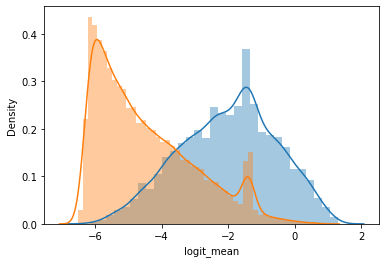

In [110]:
import seaborn as sns
temp = valid_output

sns.distplot(temp.query('died_180d==1').logit_mean)
sns.distplot(temp.query('died_180d==0').logit_mean)


/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newrx_mean', ylabel='Density'>

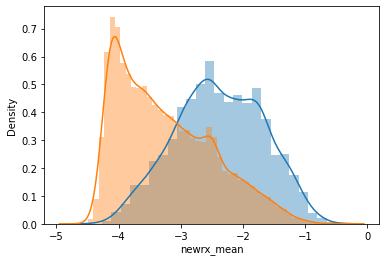

In [111]:
sns.distplot(temp.query('new_rx_30d==1').newrx_mean)
sns.distplot(temp.query('new_rx_30d==0').newrx_mean)

/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='logit_mean', ylabel='Density'>

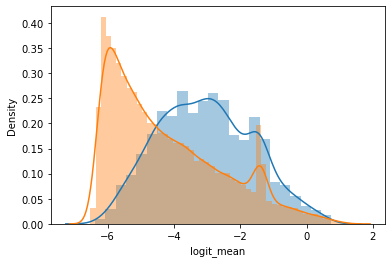

In [112]:
sns.distplot(temp.query('new_rx_30d==1').logit_mean)
sns.distplot(temp.query('new_rx_30d==0').logit_mean)

/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='newrx_mean', ylabel='Density'>

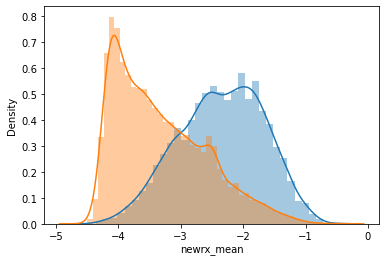

In [113]:
sns.distplot(temp.query('died_180d==1').newrx_mean)
sns.distplot(temp.query('died_180d==0').newrx_mean)

In [115]:
from lifelines.utils import concordance_index
concordance_index(valid_output.encounter_to_end, valid_output.logit_mean, valid_output.event)

0.2017671799886632

In [116]:
concordance_index(valid_output.encounter_to_end, valid_output.newrx_mean, valid_output.event)

0.23416046218565043

In [117]:
from lifelines.utils import concordance_index
temp = valid_output[~valid_output['calc_diff_logit'].isnull()]
concordance_index(temp.encounter_to_end, temp.calc_diff_logit, temp.event)

0.4356390593248273

In [118]:
from lifelines.utils import concordance_index
temp = valid_output[~valid_output['diff_logit_ewm'].isnull()]
concordance_index(temp.encounter_to_end, temp.diff_logit_ewm, temp.event)

0.3613929627903323

/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='logit_mean', ylabel='logit_sd'>

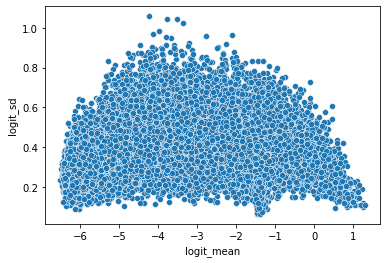

In [119]:
sns.scatterplot(valid_output.logit_mean, valid_output.logit_sd)

/homes10/klkehl/anaconda3/envs/transformer/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='newrx_mean', ylabel='newrx_sd'>

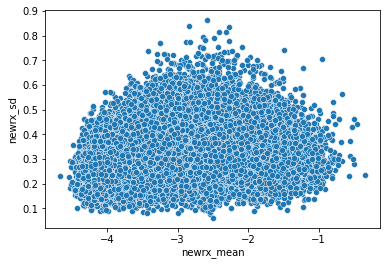

In [120]:
sns.scatterplot(valid_output.newrx_mean, valid_output.newrx_sd)

In [121]:
# find words correlated with otucome in valdiation set using LASSO model

from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,3), min_df=2, max_df=0.95)
temp = valid_output
text_matrix = vectorizer.fit_transform(temp.text).todense()

#train_text_matrix = vectorizer.transform(train_output.text).todense()
#valid_text_matrix = vectorizer.transform(valid_output.text).todense()

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import roc_auc_score, average_precision_score

lin_model = SGDRegressor(penalty='l1', 
                            alpha=0.001, random_state=42,
                            max_iter=500, tol=None)
lin_model.fit(text_matrix, temp.logit_mean)
features = pd.DataFrame()
features['coefs'] = lin_model.coef_.flatten()
features['names'] = vectorizer.get_feature_names()
features = features.sort_values(by='coefs', ascending=False)
high_prob_features = features.names[0:10]
low_prob_features = features.names[-10:]
print((features['coefs']==0).value_counts())
print(features.head(10), features.tail(10))


True     341
False    159
Name: coefs, dtype: int64
        coefs       names
268  5.633965  metastatic
77   4.650026     ascites
266  4.251324  metastases
341  3.582719     pleural
211  3.145511   increased
396  2.936600   signed by
455  2.856984  this study
283  2.574866         new
267  2.267658  metastasis
187  2.197235        head         coefs         names
346 -1.624221  postsurgical
467 -1.737014          type
100 -1.978789        breast
296 -2.023202        nodule
129 -2.029422          cyst
371 -2.181505     resection
290 -2.659115    no pleural
289 -3.756370        no new
284 -4.051114            no
107 -4.256459            cc


In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,3), min_df=2, max_df=0.95)
temp = valid_output
text_matrix = vectorizer.fit_transform(temp.text).todense()

#train_text_matrix = vectorizer.transform(train_output.text).todense()
#valid_text_matrix = vectorizer.transform(valid_output.text).todense()

from sklearn.linear_model import SGDRegressor
from sklearn.metrics import roc_auc_score, average_precision_score

lin_model = SGDRegressor(penalty='l1', 
                            alpha=0.001, random_state=42,
                            max_iter=500, tol=None)
lin_model.fit(text_matrix, temp.newrx_mean)
features = pd.DataFrame()
features['coefs'] = lin_model.coef_.flatten()
features['names'] = vectorizer.get_feature_names()
features = features.sort_values(by='coefs', ascending=False)
high_prob_features = features.names[0:10]
low_prob_features = features.names[-10:]
print((features['coefs']==0).value_counts())
print(features.head(10), features.tail(10))
# #lin_model.score(valid_text_matrix, valid_logit)


True     423
False     77
Name: coefs, dtype: int64
        coefs        names
268  4.072479   metastatic
266  3.047364   metastases
211  1.796579    increased
267  1.777115   metastasis
209  1.548435     increase
77   1.530539      ascites
210  1.349739  increase in
283  1.309670          new
126  1.077885           ct
279  1.069540     multiple         coefs         names
129 -0.724402          cyst
346 -0.749806  postsurgical
100 -0.767874        breast
394 -0.862219    signatures
154 -1.111729          exam
371 -1.332161     resection
289 -1.455164        no new
412 -1.560105        status
284 -1.614762            no
107 -1.616895            cc


In [123]:
# generate predictions for the validation set (includes events after censoring date)
themodel = PrognosisModel()
themodel.load_state_dict(torch.load(model_folder+'rnn_direct_hazard_dropout_rehazard.pt'))
themodel.to('cuda')

no_shuffle_valid_dataset = data.DataLoader(PrognosisDataset(validation), batch_size=1, shuffle=False, num_workers=0)

sample_number = 10

dflist = []
for a,b,c, _, _ in no_shuffle_valid_dataset:
    thisframe = pd.DataFrame()
    
    sample_list = []
    newrx_list = []
    for i in range(sample_number):
        with torch.no_grad():
            y_pred, newrx_pred = themodel(a.to('cuda'), b.to('cuda'), c.to('cuda'))
        logits = torch.log(y_pred.squeeze(1))
        newrx = newrx_pred.squeeze(1)
        sample_list.append(logits)
        newrx_list.append(newrx)
        
    samples = torch.stack(sample_list, dim=1)
    newrxs = torch.stack(newrx_list, dim=1)
    
    
    thisframe['logit_mean'] = torch.mean(samples, dim=1).cpu().detach().numpy()
    thisframe['logit_sd'] = torch.std(samples, dim=1).cpu().detach().numpy()
    thisframe['newrx_mean'] = torch.mean(newrxs, dim=1).cpu().detach().numpy()
    thisframe['newrx_sd'] = torch.std(newrxs, dim=1).cpu().detach().numpy()
    thisframe['calc_diff_logit'] = thisframe.logit_mean.diff()
    thisframe['ewm_logit'] = thisframe[['logit_mean']].apply(lambda x: x.ewm(span=7).mean()).values.flatten()
    thisframe['diff_logit_ewm'] = thisframe['logit_mean'] - thisframe['ewm_logit'].shift(periods=1)




    


    
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = validation.reset_index(drop=True)



valid_output = pd.concat([output, resultframe], axis=1)
valid_output = valid_output.sort_values(by=['dfci_mrn', 'encounter_date']).reset_index(drop=True)


valid_output.to_feather(derived_data_folder+'valid_predicted_prognoses_rnn_rehazard.feather')


In [124]:
# inference on test set (includes events after censoring date)
themodel = PrognosisModel()
themodel.load_state_dict(torch.load(model_folder+'rnn_direct_hazard_dropout_rehazard.pt'))
themodel.to('cuda')

no_shuffle_test_dataset = data.DataLoader(PrognosisDataset(test), batch_size=1, shuffle=False, num_workers=0)

sample_number = 10

dflist = []
for a,b,c, _, _ in no_shuffle_test_dataset:
    thisframe = pd.DataFrame()
    
    sample_list = []
    newrx_list = []
    for i in range(sample_number):
        with torch.no_grad():
            y_pred, newrx_pred = themodel(a.to('cuda'), b.to('cuda'), c.to('cuda'))
        logits = torch.log(y_pred.squeeze(1))
        newrx = newrx_pred.squeeze(1)
        sample_list.append(logits)
        newrx_list.append(newrx)
        
    samples = torch.stack(sample_list, dim=1)
    newrxs = torch.stack(newrx_list, dim=1)
    
    
    thisframe['logit_mean'] = torch.mean(samples, dim=1).cpu().detach().numpy()
    thisframe['logit_sd'] = torch.std(samples, dim=1).cpu().detach().numpy()
    thisframe['newrx_mean'] = torch.mean(newrxs, dim=1).cpu().detach().numpy()
    thisframe['newrx_sd'] = torch.std(newrxs, dim=1).cpu().detach().numpy()
    thisframe['calc_diff_logit'] = thisframe.logit_mean.diff()
    thisframe['ewm_logit'] = thisframe[['logit_mean']].apply(lambda x: x.ewm(span=7).mean()).values.flatten()
    thisframe['diff_logit_ewm'] = thisframe['logit_mean'] - thisframe['ewm_logit'].shift(periods=1)




    


    
    dflist.append(thisframe)
    
resultframe = pd.concat(dflist, axis=0)
resultframe = resultframe.reset_index(drop=True)
    

output = test.reset_index(drop=True)



test_output = pd.concat([output, resultframe], axis=1)
test_output = test_output.sort_values(by=['dfci_mrn', 'encounter_date']).reset_index(drop=True)


test_output.to_feather(derived_data_folder+'test_predicted_prognoses_rnn_rehazard.feather')


In [125]:
# now train crossval models
training_patients = training.dfci_mrn.unique()
train_actual_patients = train_actual.dfci_mrn.unique()
np.random.seed(43)
np.random.shuffle(training_patients)
splits = np.array_split(training_patients, 10)


In [126]:
for i in range(len(splits)):
    
    this_trainlist = list(set(train_actual_patients) - set(splits[i]))
    num_in_trainlist = len(this_trainlist)
    
    trainloader = data.DataLoader(PrognosisDataset(train_actual[train_actual.dfci_mrn.isin(this_trainlist)].reset_index(drop=True)), batch_size=1, num_workers=0, shuffle=True)
    validloader = data.DataLoader(PrognosisDataset(valid_actual), batch_size=1, num_workers=0, shuffle=True)


    model = PrognosisModel()
    model.to('cuda')

    print('Split: ' + str(i))
    train_model(model, 3, trainloader, validloader)
    torch.save(model.state_dict(), derived_data_folder + 'rnn_direct_hazard_dropout_rehazard_' + str(i) + '.pt')


Split: 0
Epoch: 1, batch: 15103/15103, main train loss: 0.9129692239516618, newrx train loss: 0.024572110752889657
Epoch: 1, main val loss: 0.6760185543535534, newrx val loss: 0.02484920826982913
Epoch: 2, batch: 15103/15103, main train loss: 0.6384108743777582, newrx train loss: 0.022424273649815953
Epoch: 2, main val loss: 0.600444561934001, newrx val loss: 0.022781058099477437
Epoch: 3, batch: 15103/15103, main train loss: 0.5579497314910111, newrx train loss: 0.021578119085992956
Epoch: 3, main val loss: 0.5826760336950227, newrx val loss: 0.022334593105855154
Split: 1
Epoch: 1, batch: 15102/15102, main train loss: 0.8934069913518321, newrx train loss: 0.025297607653036477
Epoch: 1, main val loss: 0.6998307612608579, newrx val loss: 0.023040031009909624
Epoch: 2, batch: 15102/15102, main train loss: 0.6340611101120636, newrx train loss: 0.022085723241773612
Epoch: 2, main val loss: 0.5986478215745574, newrx val loss: 0.02314545238724748
Epoch: 3, batch: 15102/15102, main train loss

In [127]:
range(len(splits))

range(0, 10)

In [130]:
# evaluate and make datasets
for i in range(len(splits)):

    model = PrognosisModel()
    model.load_state_dict(torch.load(derived_data_folder+'rnn_direct_hazard_dropout_rehazard_' + str(i) + '.pt'))
    model.to('cuda')
    this_trainlist = list(set(splits[i]).intersection(set(training_patients)))

    trainloader = data.DataLoader(PrognosisDataset(training[training.dfci_mrn.isin(this_trainlist)].reset_index(drop=True)), batch_size=1, num_workers=0, shuffle=False)


    sample_number = 10
    
    dflist = []
    
    for a,b,c, _, _ in trainloader:
        thisframe = pd.DataFrame()
        sample_list = []
        newrx_list = []
        for j in range(sample_number):
            with torch.no_grad():
                y_pred, newrx_pred = themodel(a.to('cuda'), b.to('cuda'), c.to('cuda'))
            logits = torch.log(y_pred.squeeze(1))
            newrx = newrx_pred.squeeze(1)
            sample_list.append(logits)
            newrx_list.append(newrx)

        samples = torch.stack(sample_list, dim=1)
        newrxs = torch.stack(newrx_list, dim=1)


        thisframe['logit_mean'] = torch.mean(samples, dim=1).cpu().detach().numpy()
        thisframe['logit_sd'] = torch.std(samples, dim=1).cpu().detach().numpy()
        thisframe['newrx_mean'] = torch.mean(newrxs, dim=1).cpu().detach().numpy()
        thisframe['newrx_sd'] = torch.std(newrxs, dim=1).cpu().detach().numpy()
        thisframe['calc_diff_logit'] = thisframe.logit_mean.diff()
        thisframe['ewm_logit'] = thisframe[['logit_mean']].apply(lambda x: x.ewm(span=7).mean()).values.flatten()
        thisframe['diff_logit_ewm'] = thisframe['logit_mean'] - thisframe['ewm_logit'].shift(periods=1)


        dflist.append(thisframe)

    resultframe = pd.concat(dflist, axis=0)
    resultframe = resultframe.reset_index(drop=True)


    output = training[training.dfci_mrn.isin(this_trainlist)].reset_index(drop=True)
    output = output.sort_values(by=['dfci_mrn','encounter_date'])

    train_output = pd.concat([output, resultframe], axis=1)
    train_output = train_output.sort_values(by=['dfci_mrn', 'encounter_date']).reset_index(drop=True)

    train_output.to_feather(derived_data_folder + 'training_'+str(i)+'_predicted_prognoses_rnn_rehazard.feather')


In [131]:
dataset_list = []
for i in range(10):
    thisset = pd.read_feather(derived_data_folder+'training_'+str(i)+'_predicted_prognoses_rnn_rehazard.feather')
    thisset['split'] = 'train_' + str(i)
    dataset_list.append(thisset)

valid = pd.read_feather(derived_data_folder +'valid_predicted_prognoses_rnn_rehazard.feather')
valid['split'] = 'validation'
dataset_list.append(valid)

test = pd.read_feather(derived_data_folder +'test_predicted_prognoses_rnn_rehazard.feather')
test['split'] = 'test'
dataset_list.append(test)

In [133]:
all_profile_no_test = pd.concat(dataset_list, axis=0)
all_profile_no_test = all_profile_no_test.sort_values(by=['dfci_mrn', 'encounter_date']).reset_index(drop=True)



all_profile_no_test['genomic_report_date'] = all_profile_no_test['report_dt']
#all_profile_no_test['genomic_specimen_date'] = all_profile_no_test['specimen_date']
all_profile_no_test = all_profile_no_test[['dfci_mrn', 'primary_cancer_diagnosis', 'encounter_date', 'text', 'encounter_to_end', 'event', 'event_date', 'after_palliative', 'after_profile', 'died_180d', 'new_rx_30d','genomic_report_date', 'split', 'starttime', 'time', 'logit_mean', 'logit_sd', 'newrx_mean', 'newrx_sd','calc_diff_logit', 'ewm_logit', 'diff_logit_ewm']]
all_profile_no_test.to_feather(derived_data_folder+'all_profile_predicted_prognoses_rnn_rehazard.feather')

In [134]:
import pandas as pd
progdata = pd.read_feather(derived_data_folder+'all_profile_predicted_prognoses_rnn_rehazard.feather')

In [136]:
progdata.split.value_counts()

test          46684
validation    44003
train_8       38460
train_6       38220
train_2       37771
train_5       36861
train_7       36592
train_3       36555
train_9       36356
train_1       36159
train_0       36094
train_4       35470
Name: split, dtype: int64